# New PVIS Solar Position Algorithm Plots (Based on NOAA)


Solar position is a fundamental aspect of solar resource assessment. The different angles used in the reference system to locate the sun at a particular time and location are probably the most common input in solar resource modelling and assessment.

In this section, we cover:

- Solar positionsystem

- Solar position agorithms

- Applications of solar position.

## Importing package and modules

In [2]:
from zoneinfo import ZoneInfo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from pvgisprototype.api.position.overview_series import model_solar_geometry_overview_time_series
from pvgisprototype import Longitude
from pvgisprototype import Latitude
from pvgisprototype import SurfaceOrientation
from pvgisprototype import SurfaceTilt
from pvgisprototype.constants import DEGREES
from pvgisprototype.api.position.models import SolarPositionModel
from pvgisprototype.api.position.models import SolarIncidenceModel


## Preparing data for ESTI Ispra (45.812, 8.628)

In [3]:
# Location
latitude = Latitude(value = 45.812, unit = DEGREES)
longitude = Longitude(value = 8.628, unit = DEGREES)

In [4]:
# Timezone
timezone = ZoneInfo("UTC")

In [5]:
# Get specific dates in this case all 2018
timestamps = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:59:00', freq='h', tz=timezone)

In [6]:
# Orientation and Tilt
surface_orientation = SurfaceOrientation(value = 0.001, unit = DEGREES)
surface_tilt = SurfaceTilt(value = 45, unit = DEGREES)

And as simple as that we can get the solar position for this specific timestamps and location

In [7]:
position = model_solar_geometry_overview_time_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angles=False,
)

Converting data to dataframe for easy visualization

In [8]:
data = pd.DataFrame({'Datetime': timestamps, 
                   'Solar Declination': position[0].degrees,
                   'Solar Hour Angle': position[1].degrees,
                   'Solar Zenith': position[2].degrees,
                   'Solar Altitude': position[3].degrees,
                   'Solar Azimuth': position[4].degrees,
                   'Solar Incidence':position[7].degrees,
        })
data.set_index('Datetime', inplace=True)

## Plotting solar zenith and azimuth for 21 of June (2018) over ESTI Ispra

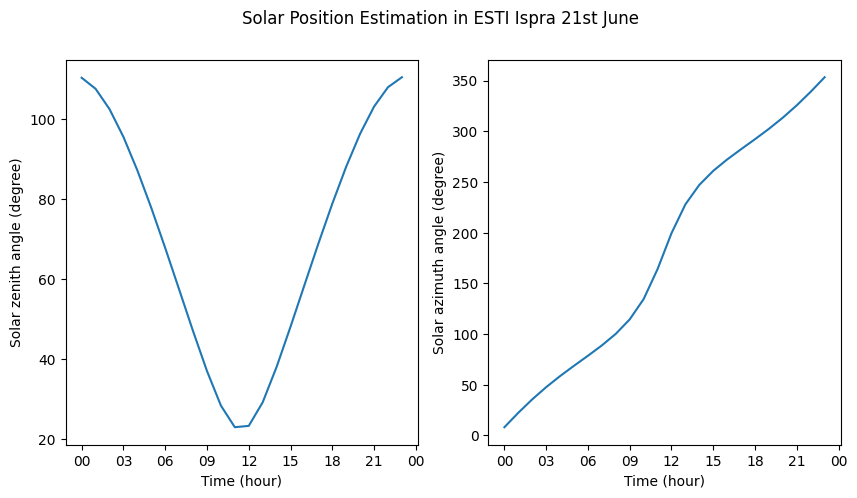

In [9]:
# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Solar Position Estimation in ESTI Ispra 21st June')

# plot for solar zenith angle
ax1.plot(data.loc['2018-06-21']['Solar Zenith'])
ax1.set_ylabel('Solar zenith angle (degree)')
ax1.set_xlabel('Time (hour)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth angle
ax2.plot(data.loc['2018-06-21']['Solar Azimuth'])
ax2.set_ylabel('Solar azimuth angle (degree)')
ax2.set_xlabel('Time (hour)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

## Solar position algorithms

Bellow we will test the differences in solar zenith and solar azimuth between the new PVGIS (NOAA) and PVLIB (NREL model, PyEphem, Ephemeris)

In [10]:
# Prepare pvlib data
import pvlib
from pvlib.location import Location
site = Location(45.812, 8.628, 'UTC', 200, 'ESTI Ispra') # latitude, longitude, time_zone, altitude, name

# Definition of a time range of simulation
times = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:59:00', freq='h', tz=site.tz)

solpos_nrel = pvlib.solarposition.get_solarposition(times, site.latitude, site.longitude, site.altitude, method='nrel_numpy')
solpos_pyephem = pvlib.solarposition.get_solarposition(times, site.latitude, site.longitude, site.altitude, method='pyephem')
solpos_ephemeris = pvlib.solarposition.get_solarposition(times, site.latitude, site.longitude, site.altitude, method='ephemeris')

We can visualize the differences in the estimations of the **solar zenith angle**:

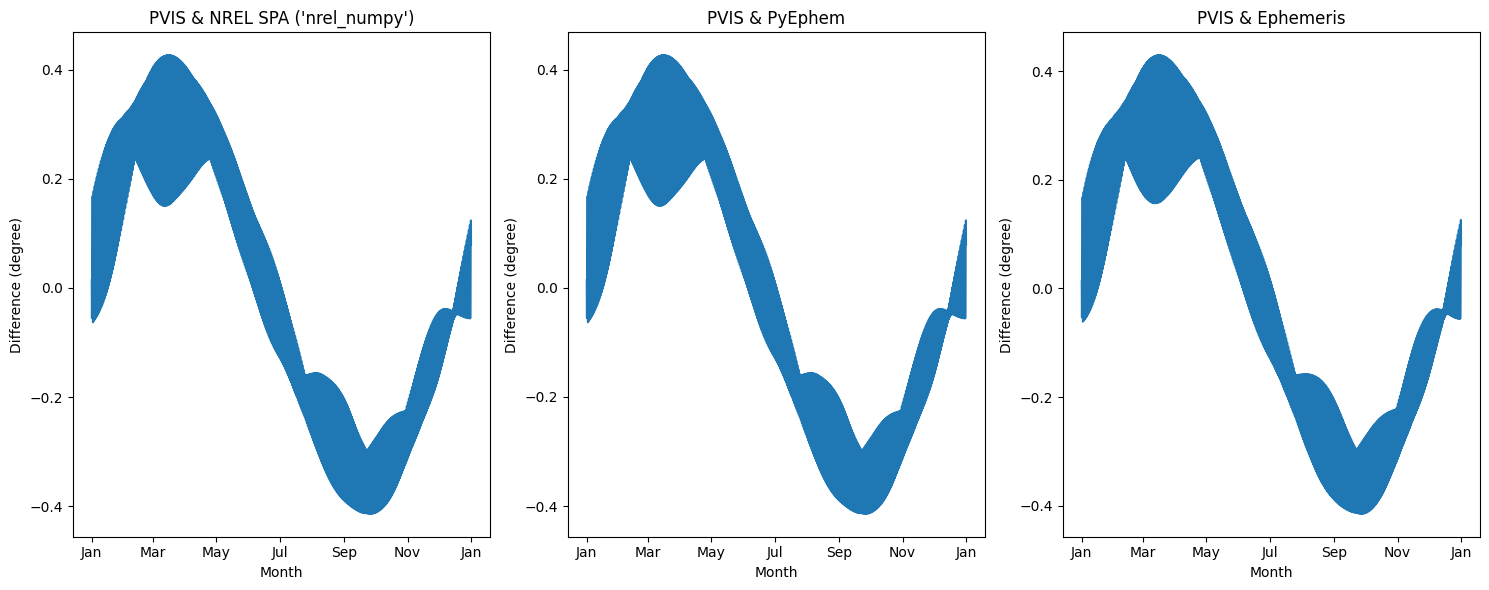

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].plot(data['Solar Zenith']-solpos_nrel['zenith'])
axs[1].plot(data['Solar Zenith']-solpos_pyephem['zenith'])
axs[2].plot(data['Solar Zenith']-solpos_ephemeris['zenith'])

# Add characteristics to each subplot in a loop
plots = ["PVIS & NREL SPA ('nrel_numpy')", "PVIS & PyEphem", "PVIS & Ephemeris"]
for i in range(3):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degree)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

Then we can visualize the differences in the estimations of the **solar azimuth angle** as well:

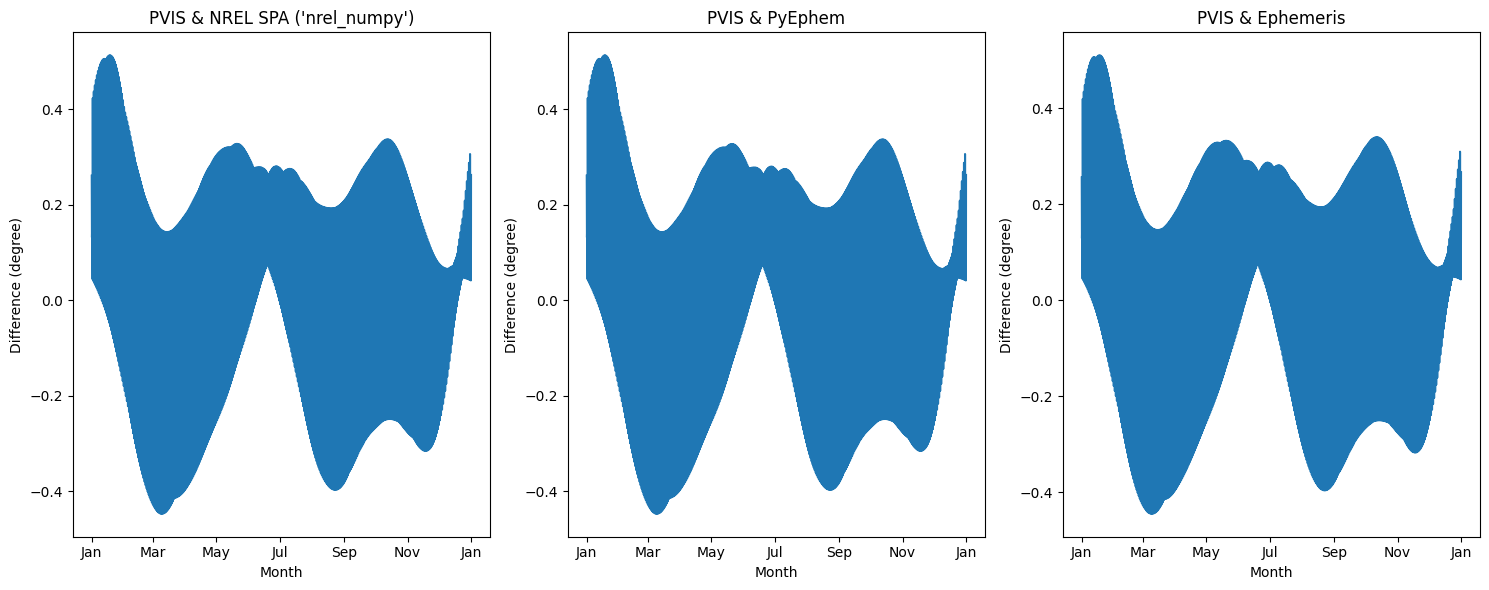

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

axs[0].plot(data['Solar Azimuth']-solpos_nrel['azimuth'])
axs[1].plot(data['Solar Azimuth']-solpos_pyephem['azimuth'])
axs[2].plot(data['Solar Azimuth']-solpos_ephemeris['azimuth'])

# Add characteristics to each subplot in a loop
plots = ["PVIS & NREL SPA ('nrel_numpy')", "PVIS & PyEphem", "PVIS & Ephemeris"]
for i in range(3):
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Difference (degree)')
    axs[i].set_title(plots[i])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

The absolute differences between methods can then be computed:

In [13]:
# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_sza = np.abs(data['Solar Zenith']-solpos_nrel['zenith']).max()
pvis_ephemeris_sza = np.abs(data['Solar Zenith']-solpos_ephemeris['zenith']).max()
pvis_pyephem_sza = np.abs(data['Solar Zenith']-solpos_pyephem['zenith']).max()

# list of variables 
methods_sza = [pvis_nrel_sza, pvis_ephemeris_sza, pvis_pyephem_sza] # Solar Zenith Angle

# compute the absolute difference in Solar Zenith Angle between SPA methods
pvis_nrel_azi = np.abs(data['Solar Azimuth']-solpos_nrel['azimuth']).max()
pvis_ephemeris_azi = np.abs(data['Solar Azimuth']-solpos_ephemeris['azimuth']).max()
pvis_pyephem_azi = np.abs(data['Solar Azimuth']-solpos_pyephem['azimuth']).max()

# list of variables 
methods_azi = [pvis_nrel_azi, pvis_ephemeris_azi, pvis_pyephem_azi] # Solar Azimuth Angle

spa_names = ["PVIS & NREL SPA ('nrel_numpy')", "PVIS & PyEphem", "PVIS & Ephemeris"]

print("Absolute differences between solar position algorithms:\n" + "-"*55)
print("Solar Zenith Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_sza[i]))

print("\nSolar Azimuth Angle [Degrees]")
for i in range(len(spa_names)):
    print("-", spa_names[i], ": {:.5f}".format(methods_azi[i]))

Absolute differences between solar position algorithms:
-------------------------------------------------------
Solar Zenith Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 0.42615
- PVIS & PyEphem : 0.42930
- PVIS & Ephemeris : 0.42616

Solar Azimuth Angle [Degrees]
- PVIS & NREL SPA ('nrel_numpy') : 0.51270
- PVIS & PyEphem : 0.51030
- PVIS & Ephemeris : 0.51292


## Applications of solar position

The use of solar position algorithms in solar resource can have several direct applications. For example, the visualization of sun path diagrams or the estimation of sunrise, sunset and solar transit time.

### The solar analemma

One of the applications of solar position can creating the solar analemma. An analemma is a diagram showing the position of the Sun in the sky as seen from a fixed location on Earth at the same mean solar time. In Python, we could implement the analemma as follows:

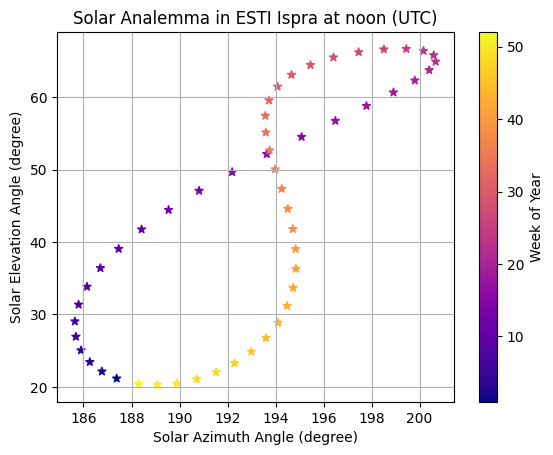

In [14]:
# Get specific dates in this case all 2018
timestamps = pd.date_range('2020-01-01 12:00:00', '2021-01-01 12:00:00', freq='W', tz=timezone)

position = model_solar_geometry_overview_time_series(
    longitude=longitude,
    latitude=latitude,
    timestamps=timestamps,
    timezone=timezone,
    surface_orientation=surface_orientation,
    surface_tilt=surface_tilt,
    solar_position_model=SolarPositionModel.noaa,
    apply_atmospheric_refraction=False,
    solar_incidence_model=SolarIncidenceModel.iqbal,
    zero_negative_solar_incidence_angles=False,
)

data = pd.DataFrame({'Datetime': timestamps, 
                   'Solar Declination': position[0].degrees,
                   'Solar Hour Angle': position[1].degrees,
                   'Solar Zenith': position[2].degrees,
                   'Solar Altitude': position[3].degrees,
                   'Solar Azimuth': position[4].degrees,
                   'Solar Incidence':position[7].degrees,
                    })

# Plotting the Analemma
plt.scatter(data['Solar Azimuth'], data['Solar Altitude'], marker="*", c=timestamps.isocalendar().week, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Week of Year')
plt.xlabel('Solar Azimuth Angle (degree)')
plt.ylabel('Solar Elevation Angle (degree)')
plt.title('Solar Analemma in ESTI Ispra at noon (UTC)')
plt.grid()
plt.show()